In [2]:
from pathlib import Path
import re
import sys
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy import interpolate

In [3]:
# Define standard column aliases
T = 'Test_Time(s)'
I = 'Current(A)'
V = 'Voltage(V)'
V_sm = 'Voltage_sm (V)'
Qc = 'Charge_Capacity(Ah)'
Qd = 'Discharge_Capacity(Ah)'
Ec = 'Charge_Energy(Wh)'
Ed = 'Discharge_Energy(Wh)'
P = 'Power(W)'

In [4]:
df = pd.read_excel(r"D:\FUSE 2025 SUM\battery-analysis-project\Data\raw_data\03-CONSTANT CURRENT protocol_Cycles 0 to 1000\Cycle 0370\CC_eleven_Channel_5_Wb_1.xlsx") # randomly picked

In [28]:
print(df.columns.tolist())

['Data_Point', 'Date_Time', 'Test_Time(s)', 'Step_Time(s)', 'Cycle_Index', 'Step_Index', 'TC_Counter1', 'TC_Counter2', 'TC_Counter3', 'TC_Counter4', 'Current(A)', 'Voltage(V)', 'Power(W)', 'Charge_Capacity(Ah)', 'Discharge_Capacity(Ah)', 'Charge_Energy(Wh)', 'Discharge_Energy(Wh)', 'ACR(Ohm)', 'dV/dt(V/s)', 'Internal_Resistance(Ohm)', 'dQ/dV(Ah/V)', 'dV/dQ(V/Ah)', 'MetaCode_MV_UD3', 'Aux_Temperature_5(C)', 'Aux_dT/dt_5(C)', 'Aux_Digital Output_1', 'Aux_Digital Output_2', 'Aux_Digital Output_3', 'Aux_Digital Output_4', 'Aux_Digital Output_5', 'Aux_Digital Output_6', 'Aux_Digital Output_7', 'Aux_Digital Output_8']


In [62]:
df = df[df['Cycle_Index']==1] # pick out a nice, complete cycle - info from previous work

Text(0.5, 1.0, 'Raw P-E Curve')

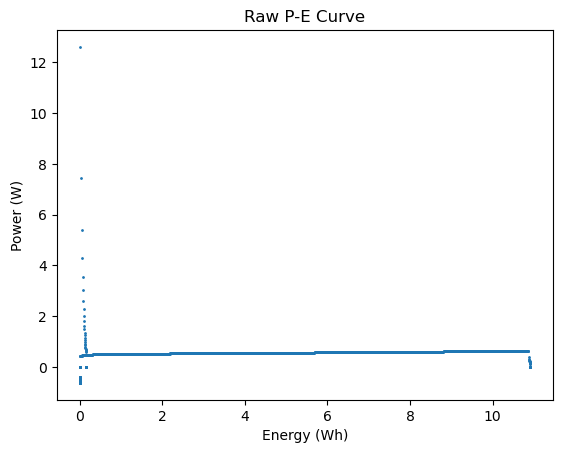

In [30]:
# check reliability of the P, E columns in the Borealis dataset
plt.plot(df[Ec], df[P], linestyle = 'none', marker = 'o', markersize = 1)
plt.xlabel("Energy (Wh)")
plt.ylabel("Power (W)")
plt.title("Raw P-E Curve")

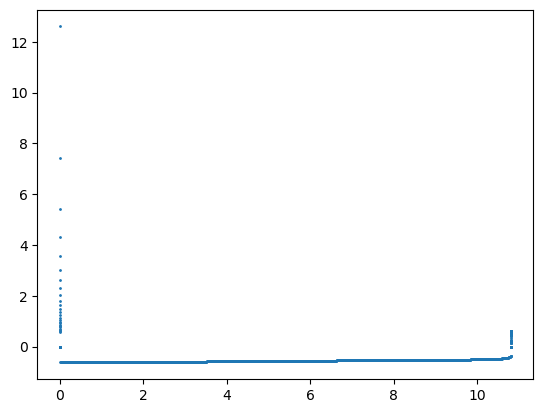

In [31]:
plt.plot(df[Ed], df[P], linestyle = 'none', marker = 'o', markersize = 1)

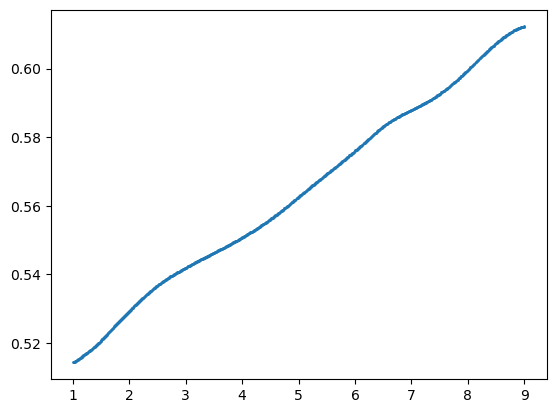

In [32]:
mask = (df[Ec] > 1) & (df[Ec] < 9)
plt.plot(df[Ec][mask], df[P][mask], linestyle='none', marker='o', markersize=1)

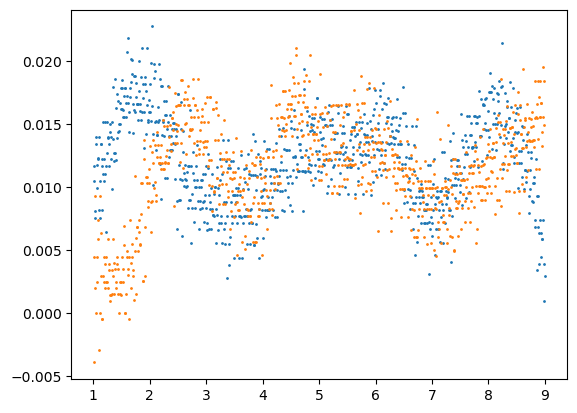

In [76]:
# check dPdE computed by raw P and E
charge = [P, Ec]
discharge = [P, Ed]

mask_c = df[charge].isna().any(axis = 1)|(df[charge]==0).any(axis=1)
mask_d = df[discharge].isna().any(axis = 1)|(df[discharge]==0).any(axis=1)

cleaned_c = df[~mask_c]
cleaned_d = df[~mask_d]

mask_c = (cleaned_c[Ec] > 1) & (cleaned_c[Ec] < 9)
mask_d = (cleaned_d[Ed] > 1) & (cleaned_d[Ed] < 9)

Pc, Ec_vals = cleaned_c[P][mask_c].values, cleaned_c[Ec][mask_c].values
dPdE_c = np.gradient(Pc, Ec_vals)
Pd, Ed_vals = cleaned_d[P][mask_d].values, cleaned_d[Ed][mask_d].values
dPdE_d = np.gradient(Pd, Ed_vals)

plt.plot(Ec_vals, dPdE_c, linestyle='none', marker='o', markersize=1)
plt.plot(Ed_vals, dPdE_d, linestyle='none', marker='o', markersize=1)

In [77]:
print(np.all(np.diff(Ec_vals) > 0)) # 'True' if monotonic

True


In [78]:
print(np.sum(np.diff(Ec_vals) == 0)) # check repeating

0


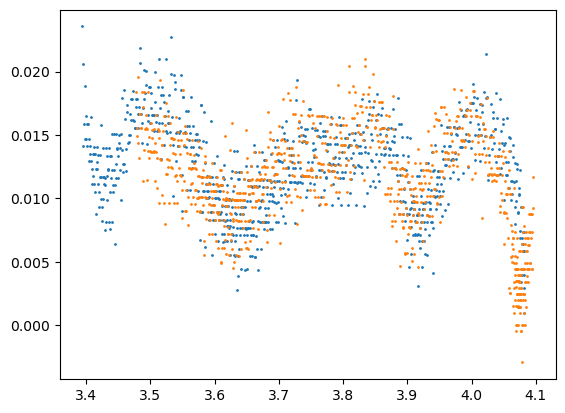

In [79]:
# try plotting against voltage
charge = [P, Ec, V]
discharge = [P, Ed, V]

mask_c = df[charge].isna().any(axis = 1)|(df[charge]==0).any(axis=1)
mask_d = df[discharge].isna().any(axis = 1)|(df[discharge]==0).any(axis=1)

cleaned_c = df[~mask_c]
cleaned_d = df[~mask_d]

mask_c = (cleaned_c[Ec] > 0.6) & (cleaned_c[Ec] < 9)
mask_d = (cleaned_d[Ed] > 0.6) & (cleaned_d[Ed] < 9)

Pc, Ec_vals, Vc = cleaned_c[P][mask_c].values, cleaned_c[Ec][mask_c].values, cleaned_c[V][mask_c].values
dPdE_c = np.gradient(Pc, Ec_vals)
Pd, Ed_vals, Vd = cleaned_d[P][mask_d].values, cleaned_d[Ed][mask_d].values, cleaned_d[V][mask_d].values
dPdE_d = np.gradient(Pd, Ed_vals)

plt.plot(Vc, dPdE_c, linestyle='none', marker='o', markersize=1)
plt.plot(Vd, dPdE_d, linestyle='none', marker='o', markersize=1)

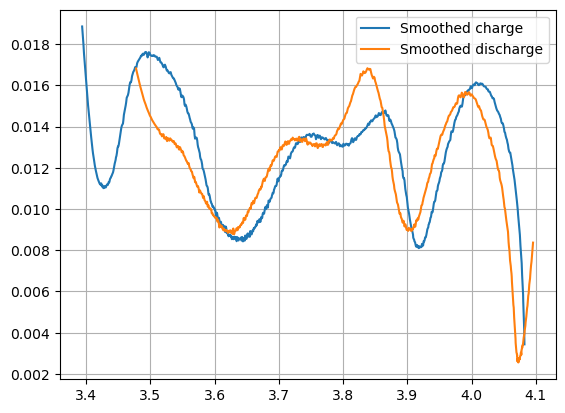

In [113]:
# try to apply some smoothing to dPdE curve
from scipy.signal import savgol_filter
dpde_smooth_c = savgol_filter(dPdE_c, window_length=75, polyorder=3)
plt.plot(Vc, dpde_smooth_c, label='Smoothed charge')

dpde_smooth_d = savgol_filter(dPdE_d, window_length=75, polyorder=3)
plt.plot(Vd, dpde_smooth_d, label='Smoothed discharge')
plt.grid(True)
plt.legend()

In [81]:
# raw P-E looked already pretty smooth, perfectly monotonic after selecting E region
# but dPdE graph still noisy -> apply smoothing -> consistent shape with dVdQ
# question for tmr: does it need smoothing before gradient is computed?

In [82]:
# should interpolate + smooth P(E) before differentiation, inspired by investigations into dVdQ

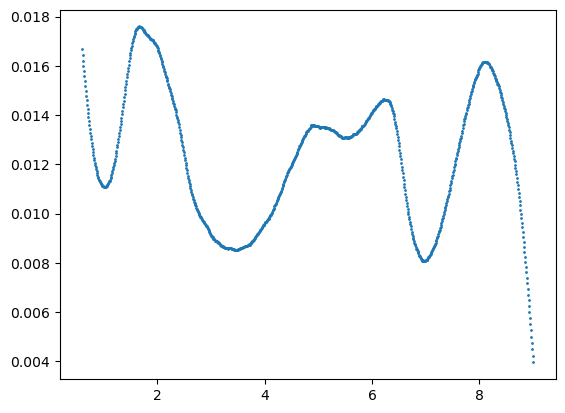

In [83]:
# interpolate
from scipy.interpolate import interp1d
Ec_uniform = np.linspace(Ec_vals.min(), Ec_vals.max(), 1000)
interp_func_ep = interp1d(Ec_vals, Pc, kind='cubic')
P_uniform = interp_func_ep(Ec_uniform)

# smooth + differentiation
dE = Ec_uniform[1] - Ec_uniform[0]
dpde = savgol_filter(P_uniform, window_length=75, polyorder=3, deriv=1, delta=dE) 

plt.plot(Ec_uniform, dpde, linestyle='none', marker='o', markersize=1)

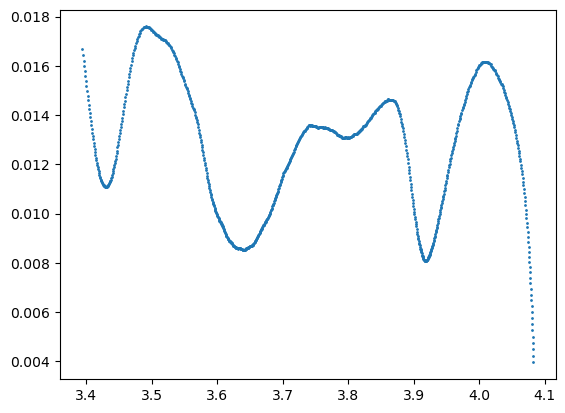

In [84]:
# plotted against interpolated voltage (wrt Energy)
interp_func_ev = interp1d(Ec_vals, Vc, kind='cubic')
V_uniform = interp_func_ev(Ec_uniform)
plt.plot(V_uniform, dpde, linestyle='none', marker='o', markersize=1)

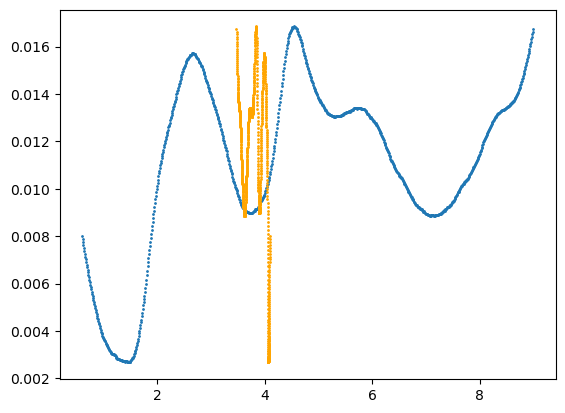

In [85]:
# do the same to discharge
from scipy.interpolate import interp1d
Ed_uniform = np.linspace(Ed_vals.min(), Ed_vals.max(), 1000)
interp_func_ep_d = interp1d(Ed_vals, Pd, kind='cubic')
Pd_uniform = interp_func_ep_d(Ed_uniform)

# smooth + differentiation
dE_d = Ed_uniform[1] - Ed_uniform[0]
dpde_d = savgol_filter(Pd_uniform, window_length=75, polyorder=3, deriv=1, delta=dE_d) 

plt.plot(Ed_uniform, dpde_d, linestyle='none', marker='o', markersize=1)
# plotted against interpolated voltage (wrt Energy)
interp_func_ev_d = interp1d(Ed_vals, Vd, kind='cubic')
Vd_uniform = interp_func_ev_d(Ed_uniform)
plt.plot(Vd_uniform, dpde_d, linestyle='none', marker='o', markersize=1, color = 'orange')

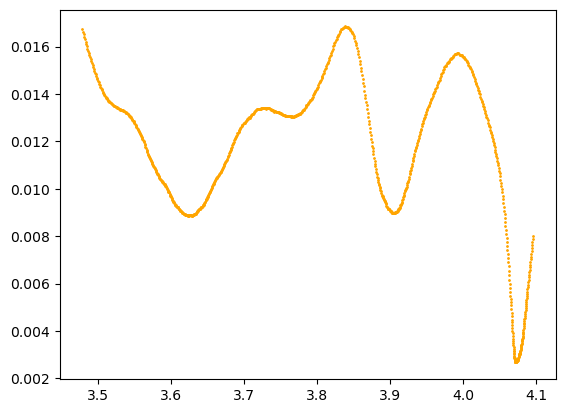

In [86]:
# plotted against interpolated voltage (wrt Energy)
interp_func_ev_d = interp1d(Ed_vals, Vd, kind='cubic')
Vd_uniform = interp_func_ev_d(Ed_uniform)
plt.plot(Vd_uniform, dpde_d, linestyle='none', marker='o', markersize=1, color = 'orange')

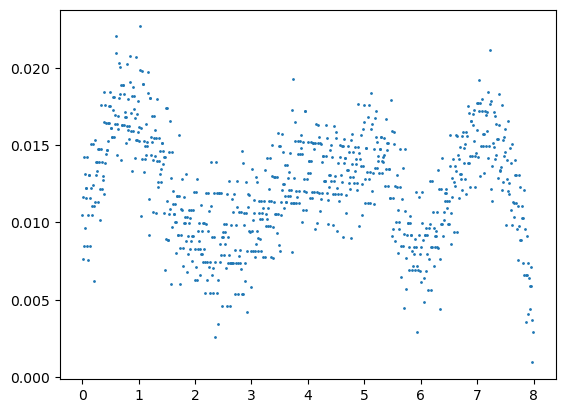

In [102]:
# compute power from current*volatage, energy from integration of power wrt time, to compare with given data

# use the same mask as above for easier comparison
mask_c = (df[Ec] > 1) & (df[Ec] < 9)
df_temp = df[mask_c].copy()
df_temp[P] = df_temp[I] * df_temp[V]

from scipy.integrate import cumulative_trapezoid
df_temp[T] = df_temp[T]/3600 # convert s to h
df_temp['Energy'] = cumulative_trapezoid(df_temp[P], df_temp[T], initial=0)

dpde_compute = np.gradient(df_temp[P], df_temp['Energy'])

plt.plot(df_temp["Energy"], dpde_compute, linestyle='none', marker='o', markersize=1)

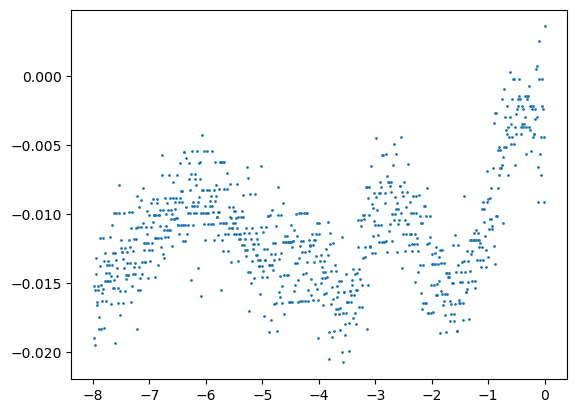

In [103]:
mask_d =  (df[Ed] > 1) & (df[Ed] < 9)
df_temp_d = df[mask_d].copy()
df_temp_d[P] = df_temp_d[I] * df_temp_d[V]

from scipy.integrate import cumulative_trapezoid
df_temp_d[T] = df_temp_d[T]/3600 # convert s to h
df_temp_d['Energy'] = cumulative_trapezoid(df_temp_d[P], df_temp_d[T], initial=0)

dpde_compute_d = np.gradient(df_temp_d[P], df_temp_d['Energy'])

plt.plot(df_temp_d["Energy"], dpde_compute_d, linestyle='none', marker='o', markersize=1)

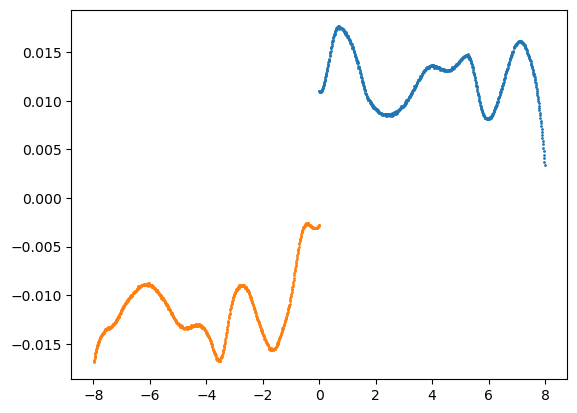

In [104]:
# apply smoothing to derivative curves just to check the shapes
dpde_com_smooth_c = savgol_filter(dpde_compute, window_length=75, polyorder=3)
dpde_com_smooth_d = savgol_filter(dpde_compute_d, window_length=75, polyorder=3)
plt.plot(df_temp["Energy"], dpde_com_smooth_c, linestyle='none', marker='o', markersize=1)
plt.plot(df_temp_d["Energy"], dpde_com_smooth_d, linestyle='none', marker='o', markersize=1)

Text(0, 0.5, 'dP/dE')

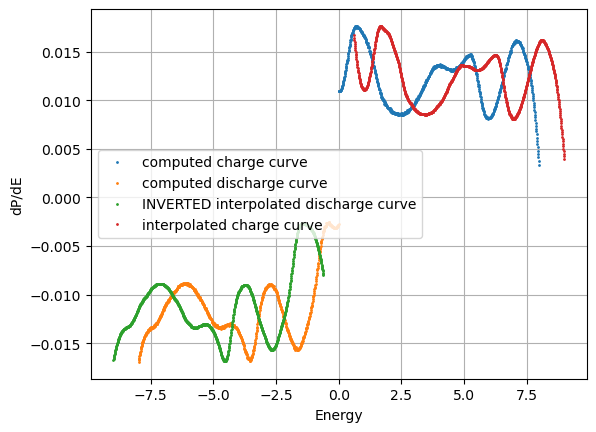

In [117]:
# plot raw and computed dPdE on the same plot to compare
plt.plot(df_temp["Energy"], dpde_com_smooth_c, linestyle='none', marker='o', markersize=1, label = 'computed charge curve')
plt.plot(df_temp_d["Energy"], dpde_com_smooth_d, linestyle='none', marker='o', markersize=1, label = 'computed discharge curve')
plt.plot(-Ed_uniform, -dpde_d, linestyle='none', marker='o', markersize=1, label = 'INVERTED interpolated discharge curve')
plt.plot(Ec_uniform, dpde, linestyle='none', marker='o', markersize=1, label = 'interpolated charge curve')
plt.legend()
plt.grid(True)
plt.xlabel('Energy')
plt.ylabel('dP/dE')

Text(0, 0.5, 'dP/dE')

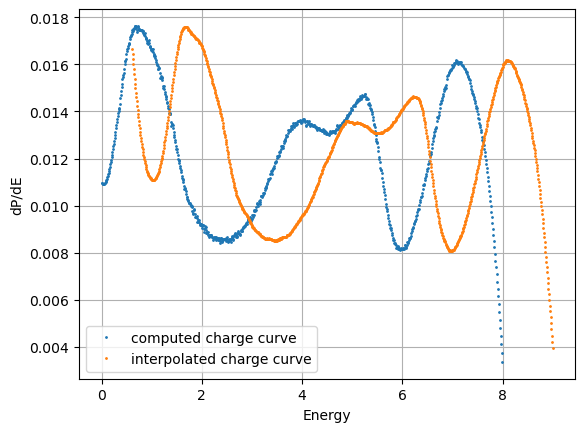

In [118]:
# plot for each pair
plt.plot(df_temp["Energy"], dpde_com_smooth_c, linestyle='none', marker='o', markersize=1, label = 'computed charge curve')
plt.plot(Ec_uniform, dpde, linestyle='none', marker='o', markersize=1, label = 'interpolated charge curve')
plt.legend()
plt.grid(True)
plt.xlabel('Energy')
plt.ylabel('dP/dE')

Text(0, 0.5, 'dP/dE')

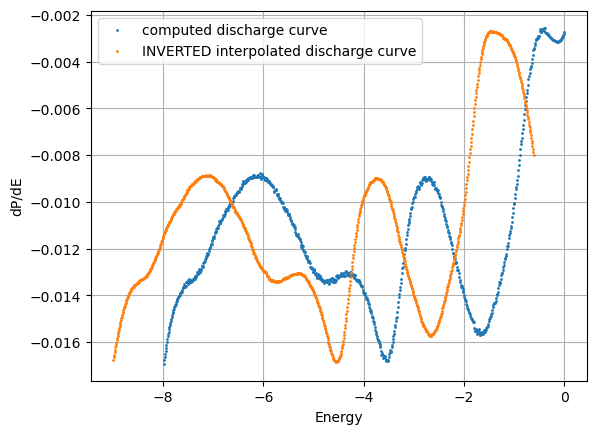

In [119]:
plt.plot(df_temp_d["Energy"], dpde_com_smooth_d, linestyle='none', marker='o', markersize=1, label = 'computed discharge curve')
plt.plot(-Ed_uniform, -dpde_d, linestyle='none', marker='o', markersize=1, label = 'INVERTED interpolated discharge curve')
plt.legend()
plt.grid(True)
plt.xlabel('Energy')
plt.ylabel('dP/dE')

Text(0, 0.5, 'dP/dE')

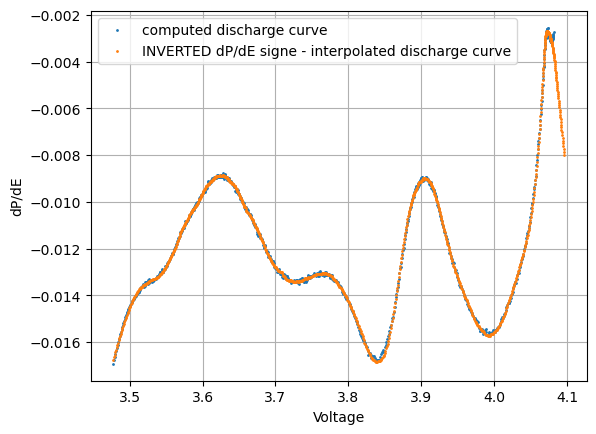

In [122]:
# found that after inverting the signs of the interpolated dishcharge dP/dE curve, their shapes almost align except a horizontal shift in each pair.Try to plot against V to see if the shift still exists
plt.plot(df_temp_d[V], dpde_com_smooth_d, linestyle='none', marker='o', markersize=1, label = 'computed discharge curve')
plt.plot(Vd_uniform, -dpde_d, linestyle='none', marker='o', markersize=1, label = 'INVERTED dP/dE signe - interpolated discharge curve')
plt.legend()
plt.grid(True)
plt.xlabel('Voltage')
plt.ylabel('dP/dE')
# shift vanishes, so it was solely the problem of the ends of the integration :)